In [35]:
import scvi
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 

### Max usage here 170gb. 
### Assumes GPU available for scanVI (but could do pre-processing (highest mem requirement}), then use smaller resources with GPU for integration)

# Load reference map (~60gb)

In [2]:
"""
Here we assume scRNA-seq data is being used. With Xenium data, higher-resolution annotations seemed to be achieved by mapping to scRNA-seq data also.

# dataset is available here (choose scRNA_seq)
https://cellatlas.io/studies/spatial-skin-atlas

"""

'\nHere we assume scRNA-seq data is being used. With Xenium data, higher-resolution annotations seemed to be achieved by mapping to scRNA-seq data also.\n\n# dataset is available here (choose scRNA_seq)\nhttps://cellatlas.io/studies/spatial-skin-atlas\n\n'

In [36]:
"""
PUT THE PATH TO THE REFERENCE ADATA HERE, AND THEN LOAD
"""
adata_reference_path = '/nfs/team298/ls34/adult_skin/final_adatas/adata_combined_new.h5ad.final.filtered.scrna.clean'
adata=sc.read_h5ad(adata_reference_path)
adata

AnnData object with n_obs × n_vars = 1730938 × 32732
    obs: 'sample_id', 'barcode', 'GSE', 'Site_status', 'Patient_status', 'Location', 'Age', 'Sex', 'dataset_id', 'lvl5_annotation', 'atlas_status', 'atlas_status_reynolds', 'Timepoint', 'info_id6', 'tech', 'scanvi_predictions2', 'lvl1_new', 'Site_status_binary2'
    uns: 'lvl5_annotation_colors'
    obsm: 'X_scvi', 'X_umap'

# Prepare your data

In [4]:
"""
### add path to your adata here. 

"""
adata_tomap_path = '/lustre/scratch126/cellgen/haniffa/ls34/tmp/adata_skin_prepublication_r.h5ad'
adata_tomap=sc.read_h5ad(adata_tomap_path)
adata_tomap.shape

(274834, 34621)

In [5]:
"""
check counts data
"""
try:
    print(adata_tomap.X[:10,:10].A)
except:
    print(adata_tomap.X[:10,:10].todense())
print("check this is counts data")

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
check this is counts data


In [6]:
"""
We assume data to map is unlabelled
"""
adata_tomap.obs["lvl5_annotation"] = "New/unlabelled/excluded"

In [7]:
"""
SET SAMPLE ID COLUMN FROM YOUR DATA
"""
adata_tomap.obs["sample_id"] = adata_tomap.obs["orig.ident"]
#adata_tomap.obs["sample_id"].value_counts()


In [8]:
assert "sample_id" in adata_tomap.obs.columns, "ERROR: adata.obs does not contain 'sample_id'"
# adata.obs["sample_id"] = adata.obs[PUT NAME OF SAMPLE ID COLUMN HERE]


In [9]:
"""
SET PATH TO SAVE OUTPUT AND NAME OF DATASET
"""
# base dir where model output saves + preintegration adata saves
BASE = '/lustre/scratch124/cellgen/haniffa/projects/adult_skin_v1/nobackup_output/'
DATASET="TUTORIAL"
adata_path =  BASE + f'adata_{DATASET}_and_SpatialSkinAtlas_preintegration.h5ad'


In [10]:
"""
These parameters i've used quite consistently for scrna. For xenium mapping, i would change to 10 latent and 1 layer, and reduced HVG number

# if mapping xenium, consider adding "technology" as a categorical covariate (i.e. xenium vs scrna)
# with xenium, we have only mapped 5k data. I suspect performance not as good with smaller panels

"""

N_LATENT=30
N_LAYERS=2
NEIGHBOR=20
MIN_DIST=0.1
HVG_BATCH_KEY = "sample_id"
HVG_NUMBER = 6000
run_scanvi=True # if false, will run scvi
SCANVI_LABELS_KEY="lvl5_annotation" # this is where cell type annotations are stored for SpatialSkinAtlas. We consider the new data to be unlabelled (hence adata_tomap.obs["lvl5_annotation"] = "New/unlabelled/excluded" )
SCANVI_UNLABELLED="New/unlabelled/excluded"
BATCH_SIZE=512

MAX_EPOCHS=10
EARLY_STOPPING_PATIENCE=4

CAT_COVS=[]


# Merge datasets (used 173gb with tutorial data)

In [11]:
"""
IF XENIUM DATA, REDUCE REFERENCE ADATA DOWN TO GENES ONLY FOUND IN XENIUM DATA
"""

# xenium_genes = adata_tomap.var_names
# common_genes = [g for g in xenium_genes if g in adata.var_names]

# adata = adata[:, common_genes].copy()      
# adata_tomap = adata_tomap[:, common_genes].copy()     



'\nIF XENIUM DATA, REDUCE REFERENCE ADATA DOWN TO GENES ONLY FOUND IN XENIUM DATA\n'

In [12]:
adata.var_names_make_unique()
adata_tomap.var_names_make_unique()


adata = ad.concat([adata, adata_tomap], label="Mapping_status", keys=["SpatialSkinAtlas", DATASET], join='outer')
del(adata_tomap)
import gc
gc.collect()
    


576

In [13]:
"""
We now save this data as it has all genes + counts, and we will re-load after selecting HVGs (which requires normalisation) so that we have count data again as input to scanvi
"""

adata.write(adata_path)
print(f"saved to {adata_path}")

saved to /lustre/scratch124/cellgen/haniffa/projects/adult_skin_v1/nobackup_output/adata_TUTORIAL_and_SpatialSkinAtlas_preintegration.h5ad


# Normalize data 

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Select features 

In [15]:
"""

We exclude certain genes from features, but when we tried not excluding these genes https://www.nature.com/articles/s41590-025-02267-8, it didn't change too much

Note that the file for cell cycles genes is available from '/nfs/team298/ls34/csv_files/cc_genes.csv'. This can be downloaded by uncommenting below. If not, set custom path


"""
# !wget https://raw.githubusercontent.com/haniffalab/skin_fibroblast_atlas/main/misc/cc_genes.csv -O cc_genes.csv
PATH_TO_CC_GENES="./cc_genes.csv"


In [16]:
cc_genes_csv=pd.read_csv(PATH_TO_CC_GENES,  names=["gene_ids"], skiprows=1)
cc_genes_list = list(cc_genes_csv["gene_ids"])

In [17]:
"""
this will reduce genes to select HVGs from
""" 
hypoxia = ["VEGFA",
"TF",
"SLC2A1-AS1",
"FOXN1",
"VDAC1",
"ASMT",
"PLS3",
"GPI",
"DARS",
"SNAPC1",
"SEC61G",
"GTF2IRD2B",
"SAP30",
"ZMYND8",
"RSBN1",
"BNIP3L",
"GTF2IRD2",
"STC2",
"NARF",
"HK2",
"INHA",
"PCF11",
"CBWD3",
"RAD51-AS1",
"S100P",
"HIF1A",
]
def apply_qc_thresholds(adata, MIN_N_GENES, MAX_TOTAL_COUNT, MAX_PCT_MT, label, MIN_TOTAL_COUNT=0,):
    """
    Apply thresholds to generate QC column which says if passed all
    """
    # Mark MT/ribo/Hb/cell cycle genes
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]")) 
    #adata.var["hb"] = adata.var_names.str.startswith(("HBA1", "HBA2", "HBB", "HBD","HBM", "HBZ", "HBG1", "HBG2", "HBQ1"))
    adata.var["cc_fetal"] = adata.var_names.isin(cc_genes_list)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False) #percent_top=[20],

    conditions = [
        (adata.obs['n_genes_by_counts'] < MIN_N_GENES),
        (adata.obs['pct_counts_mt'] > MAX_PCT_MT),
        (adata.obs['total_counts'] > MAX_TOTAL_COUNT),
        (adata.obs['total_counts'] < MIN_TOTAL_COUNT),
        (adata.obs['pct_counts_mt'] <= MAX_PCT_MT) & (adata.obs['n_genes_by_counts'] >= MIN_N_GENES) & 
        (adata.obs['total_counts'] <= MAX_TOTAL_COUNT)  & 
        (adata.obs['total_counts'] >= MIN_TOTAL_COUNT)
    ]
    label_suffix = label.split("_")[-1]
    #print(label_suffix)
    pass_name = "Pass_" + label_suffix
    values = ['Low_nFeature', 'High_MT', 'High total count', 'Low total count', pass_name]

    adata.obs[label] = np.select(conditions, values)
    adata.obs[label] = adata.obs[label].astype('category')

    #print(adata.obs[label].value_counts())

# QC function applied to add which genes are MT / Hb etc for feature selection. Assume QC has been performed below (apply  high qc threshold so fails cells that are ok, but not excluding at this point anyway)
apply_qc_thresholds(adata, MIN_N_GENES=500, MAX_TOTAL_COUNT=300_000, MAX_PCT_MT=20,  MIN_TOTAL_COUNT=2000, label="QC_hi")

additional_genes_to_exclude = [
    #"MMP14", 
    #"TNFAIP6", "ENO1",# "PDPN", "PTGES", "MMP2",
                             'JUND', 'HSPA1A', 'DNAJB1', 'EEF1A1', 'HSP90AA1', 'FTH1', 'FTL', 'HSPB1', 'XIST', 'VGLL3', "MEG3",
                              "JUNB", "HSPA1B",  "FOSB", "HSP90AA1", "FOS", "DNAJB4", 'HSPA6', 'JUN', "NEAT1", "SOD2", "SOD3", "G0S2", "MYC"]  #HSPA1B FOSB 'DLK1', 'FABP5']


additional_genes_to_exclude = additional_genes_to_exclude + hypoxia

mask_to_exclude = (
    adata.var.cc_fetal | 
    adata.var.hb | 
    adata.var.mt |
   # adata.var.mt2 |
    #adata.var.col |
    adata.var.ribo |
    adata.var.index.isin(additional_genes_to_exclude)
)
mask_to_include = ~mask_to_exclude
adata  = adata[:, mask_to_include].copy()

In [20]:
import gc
gc.collect()

911

In [21]:
"""
EXCLUDE SAMPLES FROM HVG CONSIDERATION IF <500 CELLS (CONSIDER CHANGING THIS IF LOTS OF SAMPLE SAMPLES)
+ GENES IF VERY VERY RARE (GIVEN REF DATASET IS 1.7m CELLS)
""" 

counts = adata.obs['sample_id'].value_counts()
small = counts[counts < 500].index.tolist()
mask = ~adata.obs['sample_id'].isin(small)
adata = adata[mask].copy()
gc.collect()

In [23]:
adata.obs.sample_id.value_counts()
adata.obs["sample_id"] = adata.obs["sample_id"].astype("category")
adata.obs["sample_id"] = adata.obs["sample_id"].cat.remove_unused_categories()
gc.collect()

0

In [24]:
sc.pp.filter_genes(adata, min_cells=10)
gc.collect()
adata.shape


(2005401, 34210)

In [25]:
sc.pp.highly_variable_genes(adata,  
                        n_top_genes=HVG_NUMBER, 
                        subset=False,
                        batch_key=HVG_BATCH_KEY,
                        check_values=False,
                       )  
# var_genes_all = adata.var.highly_variable
# var_genes_batch = adata.var.highly_variable_nbatches > 2
# var_select = adata.var.highly_variable_nbatches >= 2
# var_genes = var_select.index[var_select]
#print(f"selected {hvg_number} HVGs!")
gc.collect()
label_dict1 = adata.var['highly_variable_nbatches'].to_dict()
#adata2=sc.read_h5ad(adata_path)
label_dict2 = adata.var['highly_variable'].to_dict()


In [26]:
del(adata)
gc.collect()

2555

In [28]:
"""
Now re-load adata (so data is counts again, for scanvi/scvi input, and attach hvg info)
"""
adata=sc.read_h5ad(adata_path)
adata.var['highly_variable_nbatches'] = adata.var.index.map(label_dict1).fillna(np.nan)
adata.var['highly_variable'] = adata.var.index.map(label_dict2).fillna(False)

 

In [29]:
"""
Select HVGs using HVG information

# consider editing range of minimum HVG batches considered if not close to hvg number (not current range of 50-500 at intervals of 10, probably overkill)
"""
best_HVG_BATCH_MINIMUM = None
closest_hvg_number = None
closest_difference = float('inf')
for HVG_BATCH_MINIMUM in list(np.arange(50, 501, 10)):
    var_genes_batch = adata.var.highly_variable_nbatches > HVG_BATCH_MINIMUM
    var_select = adata.var.highly_variable_nbatches >= HVG_BATCH_MINIMUM
    var_genes = var_select.index[var_select]
    hvg_number = len(var_genes)

    difference = abs(hvg_number - HVG_NUMBER)

    # Update the best HVG_BATCH_MINIMUM if this one is closer 
    if difference < closest_difference:
        closest_difference = difference
        closest_hvg_number = hvg_number
        best_HVG_BATCH_MINIMUM = HVG_BATCH_MINIMUM
HVG_BATCH_MINIMUM=best_HVG_BATCH_MINIMUM
hvg_number=closest_hvg_number

var_select = adata.var.highly_variable_nbatches >= HVG_BATCH_MINIMUM
adata = adata[:, var_select].copy()
print(f"{hvg_number} selected -> {adata.shape}. Minimum batch number {HVG_BATCH_MINIMUM}")



 

6263 selected -> (2005772, 6263). Minimum batch number 130


In [30]:
CAT_COVS_TEMP = [x.replace("_", "").lower() for x in CAT_COVS] 
collapsed_string = "_".join(CAT_COVS_TEMP)
if len(CAT_COVS) == 0:
    model_details= "HVGNUMBER" + str(hvg_number) + "__MAXEPOCHS" + str(MAX_EPOCHS) + "__BATCHKEY" + HVG_BATCH_KEY
else:
    model_details= "HVGNUMBER" + str(hvg_number) + "__MAXEPOCHS" + str(MAX_EPOCHS) + "__BATCHKEY" + HVG_BATCH_KEY + "__COVS" + collapsed_string


In [34]:
"""
at this point could save adata, and load sep resources with GPU for mapping
"""
adata.write(adata_path+".input_scanvi")
adata_path+".input_scanvi"


'/lustre/scratch124/cellgen/haniffa/projects/adult_skin_v1/nobackup_output/adata_TUTORIAL_and_SpatialSkinAtlas_preintegration.h5ad.input_scanvi'

In [ ]:
#del(adata)
#gc.collect()
#adata=sc.read_h5ad(adata_path+".input_scanvi")
# path_for_reloading = adata_path+".input_scanvi"
# print(path_for_reloading)

In [32]:
"""
if re-loading, need to reimport packages, set hyperparameters + save directories (above)
"""
# import scvi
# import scanpy as sc
# import anndata as ad
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
 
# adata=sc.read_h5ad(path_for_reloading)

## make sure these are same used above for saving model details
# N_LATENT=30
# N_LAYERS=2
# NEIGHBOR=20
# MIN_DIST=0.1
# HVG_BATCH_KEY = "sample_id"
# HVG_NUMBER = 6000
# #HVG_BATCH_MINIMUM=80
# run_scanvi=True # if false, will run scvi
# SCANVI_LABELS_KEY="lvl5_annotation" # this is where cell type annotations are stored for SpatialSkinAtlas. We consider the new data to be unlabelled (hence adata_tomap.obs["lvl5_annotation"] = "New/unlabelled/excluded" )
# SCANVI_UNLABELLED="New/unlabelled/excluded"
# BATCH_SIZE=512

# MAX_EPOCHS=10
# EARLY_STOPPING_PATIENCE=4

# CAT_COVS=[]

# BASE = '/lustre/scratch124/cellgen/haniffa/projects/adult_skin_v1/nobackup_output/'
# DATASET="TUTORIAL

# CAT_COVS_TEMP = [x.replace("_", "").lower() for x in CAT_COVS] 
# collapsed_string = "_".join(CAT_COVS_TEMP)
# if len(CAT_COVS) == 0:
#     model_details= "HVGNUMBER" + str(adata.shape[1]) + "__MAXEPOCHS" + str(MAX_EPOCHS) + "__BATCHKEY" + HVG_BATCH_KEY
# else:
#     model_details= "HVGNUMBER" + str(adata.shape[1]) + "__MAXEPOCHS" + str(MAX_EPOCHS) + "__BATCHKEY" + HVG_BATCH_KEY + "__COVS" + collapsed_string



'\nif re-loading, need to reimport packages, set hyperparameters + save directories (above)\n'

In [33]:
STOP

NameError: name 'STOP' is not defined

# RUN SCANVI

In [ ]:
if run_scanvi==True:
    print("RUN SCANVI")
    def run_scvi(adata_hvg, max_epochs, batch_size_vae,CATEGORICAL_COV,PATIENCE=5, N_LATENT=10, N_LAYERS=1):
        DISPERSION =  'gene-batch'
        scvi.model.SCANVI.setup_anndata(adata_hvg, 
                                   #layer="counts",
                                   categorical_covariate_keys=CATEGORICAL_COV,
                                  #continuous_covariate_keys=CONTINUOUS_COV,
                                 batch_key=HVG_BATCH_KEY,
                                  labels_key=SCANVI_LABELS_KEY,
                                        unlabeled_category=SCANVI_UNLABELLED
                                       )
        model = scvi.model.SCANVI(adata_hvg, 
                        dispersion=DISPERSION,
                        n_latent = N_LATENT, 
                        n_layers = N_LAYERS,
                       )
        model.train(accelerator ='gpu', 
                    max_epochs=max_epochs,             
                    early_stopping=True,
                   early_stopping_patience=PATIENCE,
                   batch_size=batch_size_vae)
        print("model trained")
        try:
            count=1
            plt.subplots(figsize=(10, 10))
            for key in model.history.keys():
                plt.subplot(4,3,count)
                plt.plot(model.history[key])
                plt.title(key)
                count+=1
            plt.show()    
        except: 
            print("Error with count")
            try:
                print(count)
            except:
                print("can't print count")
        return adata_hvg, model
elif run_scanvi==False:
    print("RUN scvi")
    sample_key = "sample_id"
    def run_scvi(adata_hvg, max_epochs,  batch_size_vae, CATEGORICAL_COV, PATIENCE=5, N_LATENT=10, N_LAYERS=1):
        DISPERSION = 'gene-batch'
        scvi.model.SCVI.setup_anndata(adata_hvg, 
                              #        layer="counts",
                                        batch_key=HVG_BATCH_KEY,
                                       )
        model = scvi.model.SCVI(adata_hvg, 
                        dispersion=DISPERSION,
                        n_latent = N_LATENT, 
                        n_layers = N_LAYERS,
                       )
        model.train(max_epochs=max_epochs,             
                    early_stopping=True,
                    accelerator='gpu',
                   early_stopping_patience=PATIENCE, #use_gpu =True, 
                   batch_size=batch_size_vae)
        print("model trained")
        try:
            count=1
            plt.subplots(figsize=(10, 10))
            for key in model.history.keys():
                plt.subplot(4,3,count)
                plt.plot(model.history[key])
                plt.title(key)
                count+=1
            plt.show()    
        except: 
            print("Error with count")
            try:
                print(count)
            except:
                print("can't print count")
        return adata_hvg, model

adata, model_test = run_scvi(adata, 
                          max_epochs=MAX_EPOCHS, 
                      batch_size_vae=BATCH_SIZE,
                          CATEGORICAL_COV=CAT_COVS,
                   
                                       N_LATENT=N_LATENT,
                                      N_LAYERS=N_LAYERS,
                                        PATIENCE=EARLY_STOPPING_PATIENCE
                            )

# SAVE MODEL

In [ ]:
if run_scanvi==True:
    BASE_DIR = BASE + f'/SpatialSkinAtlasMapping_scanviSpatialSkinAtlasMapping_{DATASET}_{model_details}/'
    model_test.save(BASE_DIR,
                save_anndata=True,
                 overwrite=True)
else:
    BASE_DIR = BASE + f'/SpatialSkinAtlasMapping_scvi_{DATASET}_{model_details}/'
    model_test.save(BASE_DIR,
                    save_anndata=True,
                 overwrite=True)
print(f"saved to {BASE_DIR}")

# Now, we will re-load original data to cluster

In [ ]:
# load data (pre-HVG selection)
print(f"trained. now re-load adata: {adata_path}")
adata=sc.read_h5ad(adata_path)

In [ ]:
# attach scanvi embeddings + predictions
latent = model_test.get_latent_representation() 
adata.obsm["X_scanvi"] = latent


try:
    adata.obs["scanvi_predictions"]=preds
except:
    try:
        preds = model_test.predict(adata)
        adata.obs["scanvi_predictions"]=preds
    except:
        1
    try:
        preds = model_test.predict()
        adata.obs["scanvi_predictions"]=preds
    except:
        1

In [ ]:
import gc
gc.collect()

#  knn -> umap -> save

In [ ]:
# Note here that we include the atlas data in KNN construction. Alternatively this can be excluded, but we found
# good results through including it.
neighbor_id = f"neighbor_{NEIGHBOR}"   
print("start neighbours")
sc.pp.neighbors(adata, use_rep = 'X_scanvi', metric = "euclidean", n_neighbors=NEIGHBOR,key_added=neighbor_id)
print("neighbours done")
print("start umap")
sc.tl.umap(adata, min_dist=MIN_DIST, neighbors_key =neighbor_id )

In [ ]:
# save to dir with model
SAVE_PATH = BASE_DIR + f'adata_{DATASET}+{model_details}.h5ad'
adata.write(SAVE_PATH,  compression="gzip")
print(f"Saved to {SAVE_PATH}")
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d %H:%M:%S")
print(f"Saved! Time: {timestamp}")
 

# Visualise output

In [ ]:
stop

In [1]:
import scanpy as sc
adata=sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/projects/adult_skin_v1/nobackup_output//SpatialSkinAtlasMapping_scanviSpatialSkinAtlasMapping_TUTORIAL_HVGNUMBER5704__MAXEPOCHS10__BATCHKEYsample_id/adata_all_TUTORIAL+HVGNUMBER5704__MAXEPOCHS10__BATCHKEYsample_id.h5ad')

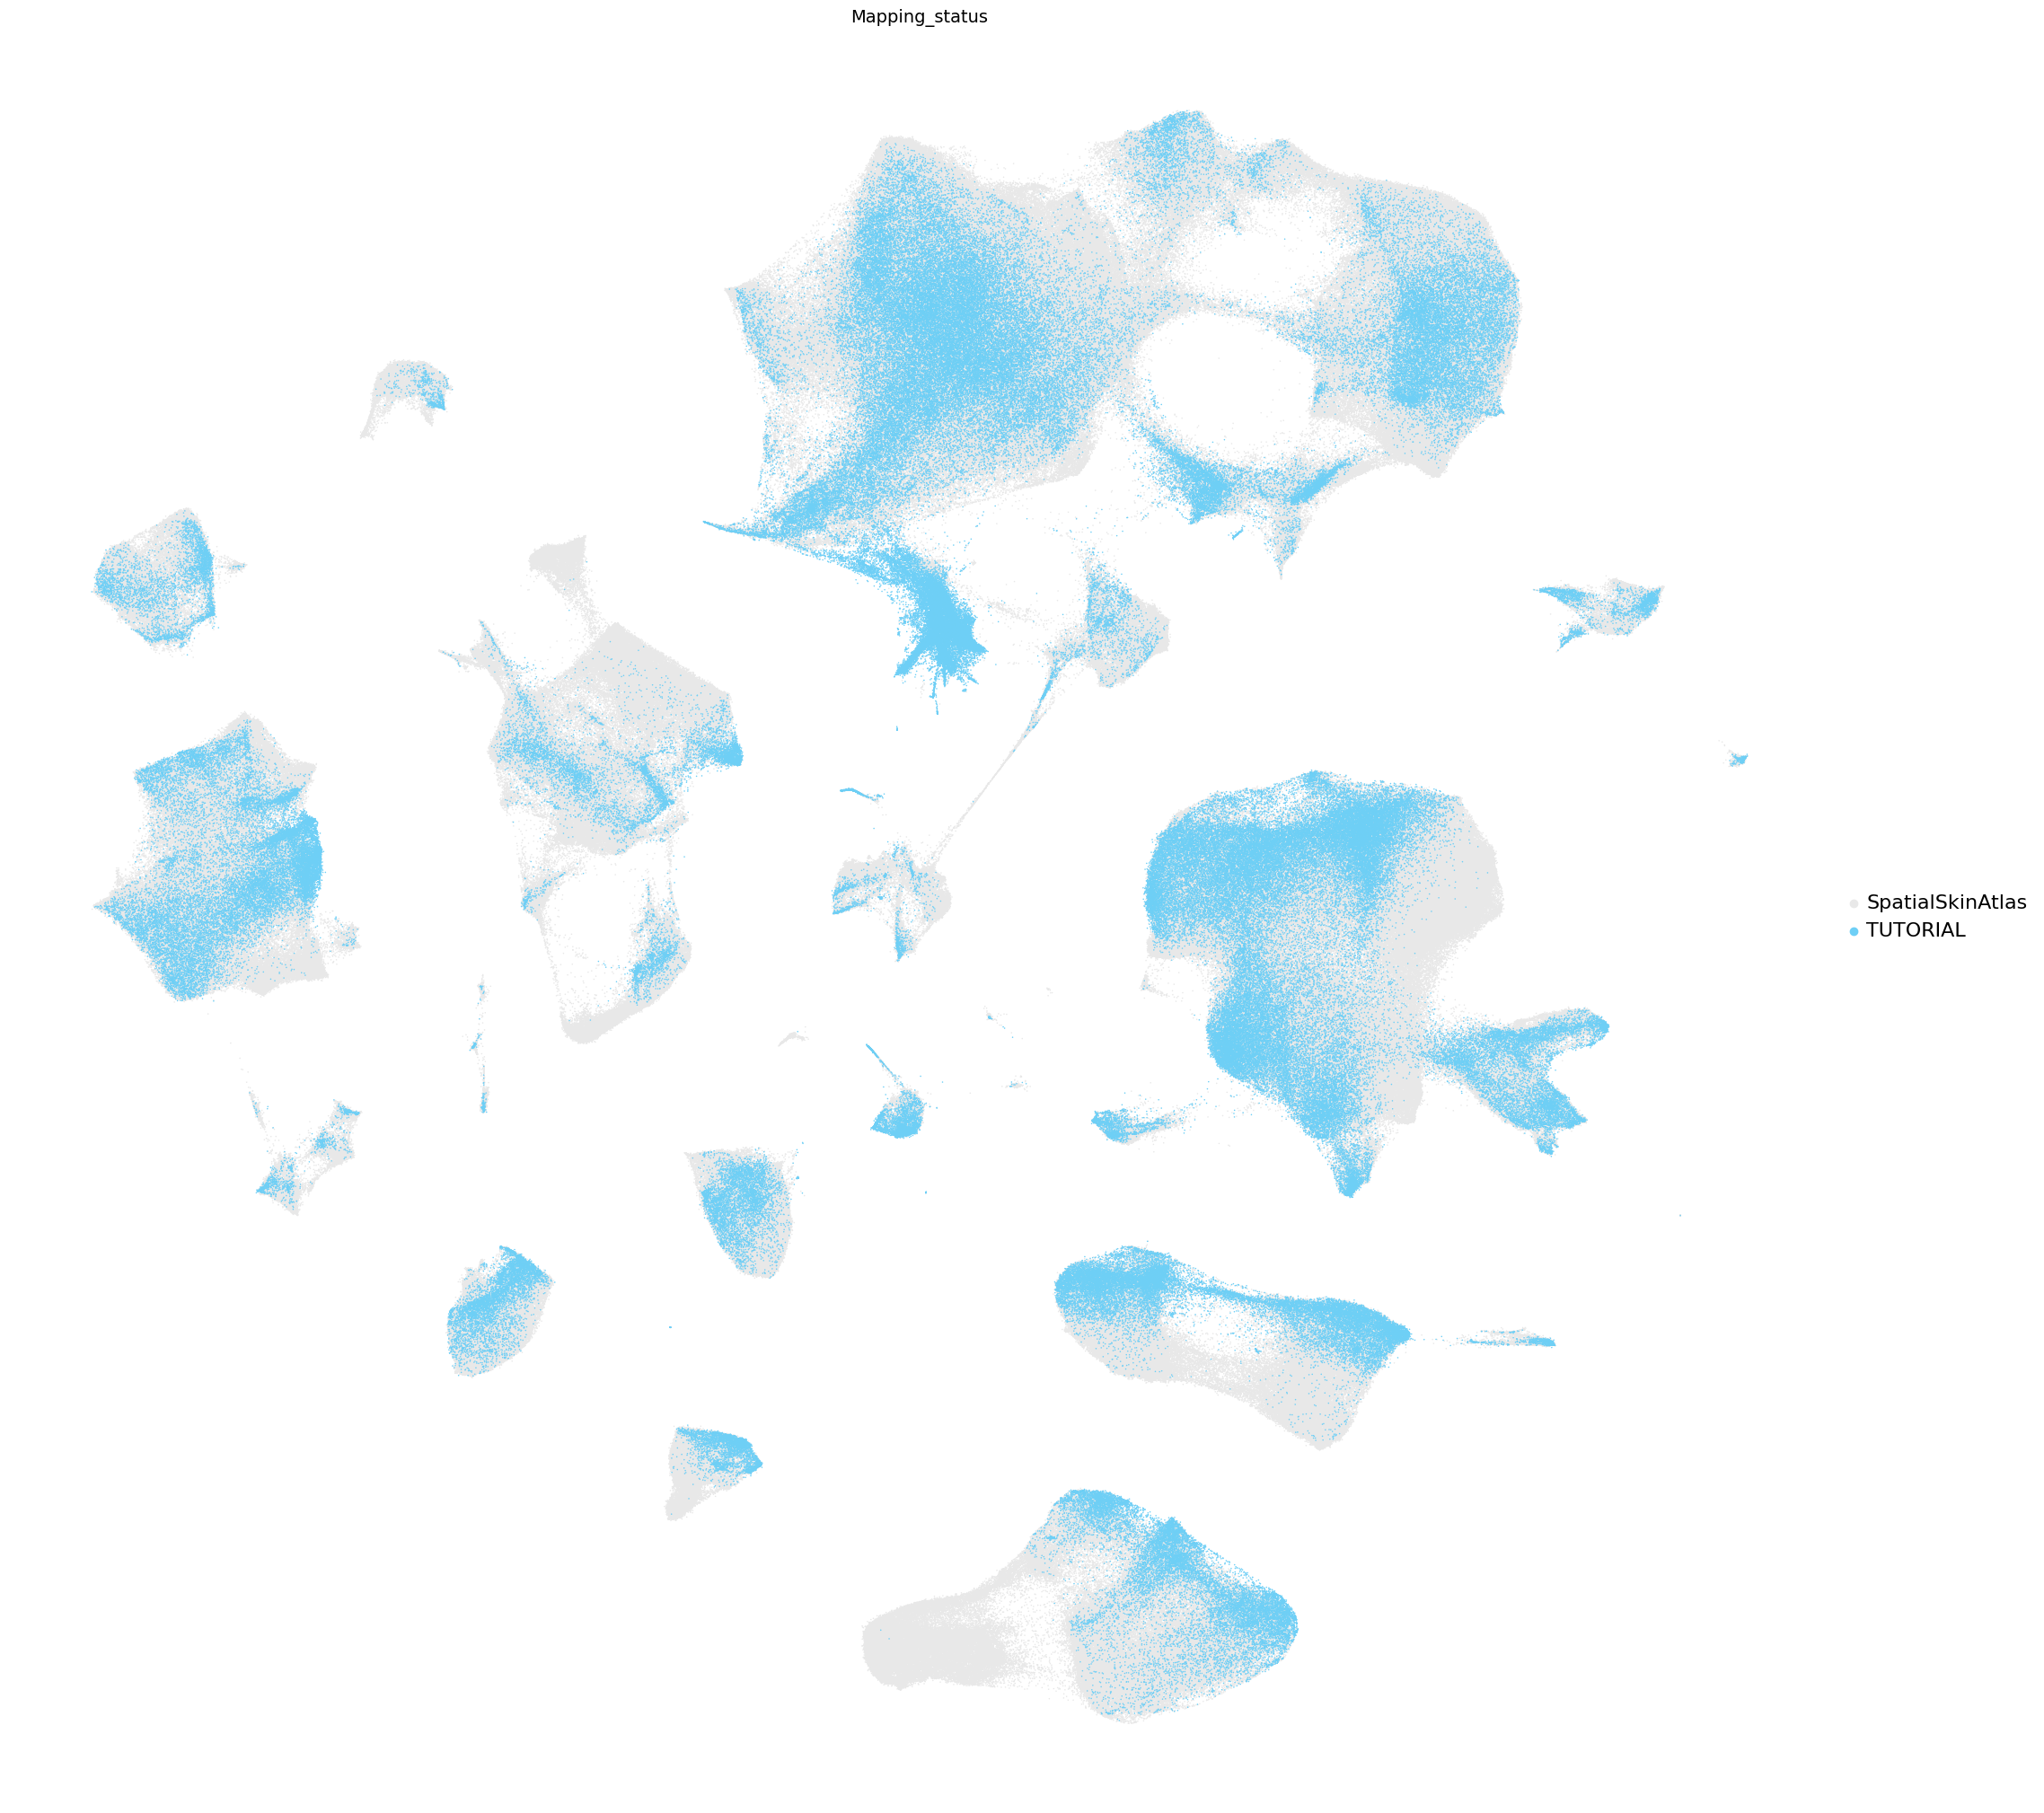

In [2]:
"""
Show how new data maps to atlas. Note that if no QC has been performed, a low QC cluster often forms (but in this dataset, QC had already been performed)

Looks like a good outcome! what a relief
"""

sc.settings.set_figure_params(dpi=50, dpi_save=300, facecolor="white", frameon=False, figsize=(26,26))

sc.pl.umap(
    adata,
    color=[
        'Mapping_status',  
    ],
    #legend_loc="on data",
    s=5, 
    legend_fontoutline=2,
    legend_fontsize=16,

       palette = {
    "SpatialSkinAtlas": "#E8E8E8",   
    "TUTORIAL": "#6ECFF6"            # swaecation sky blue
}         
)



<Axes: title={'center': 'lvl5_annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

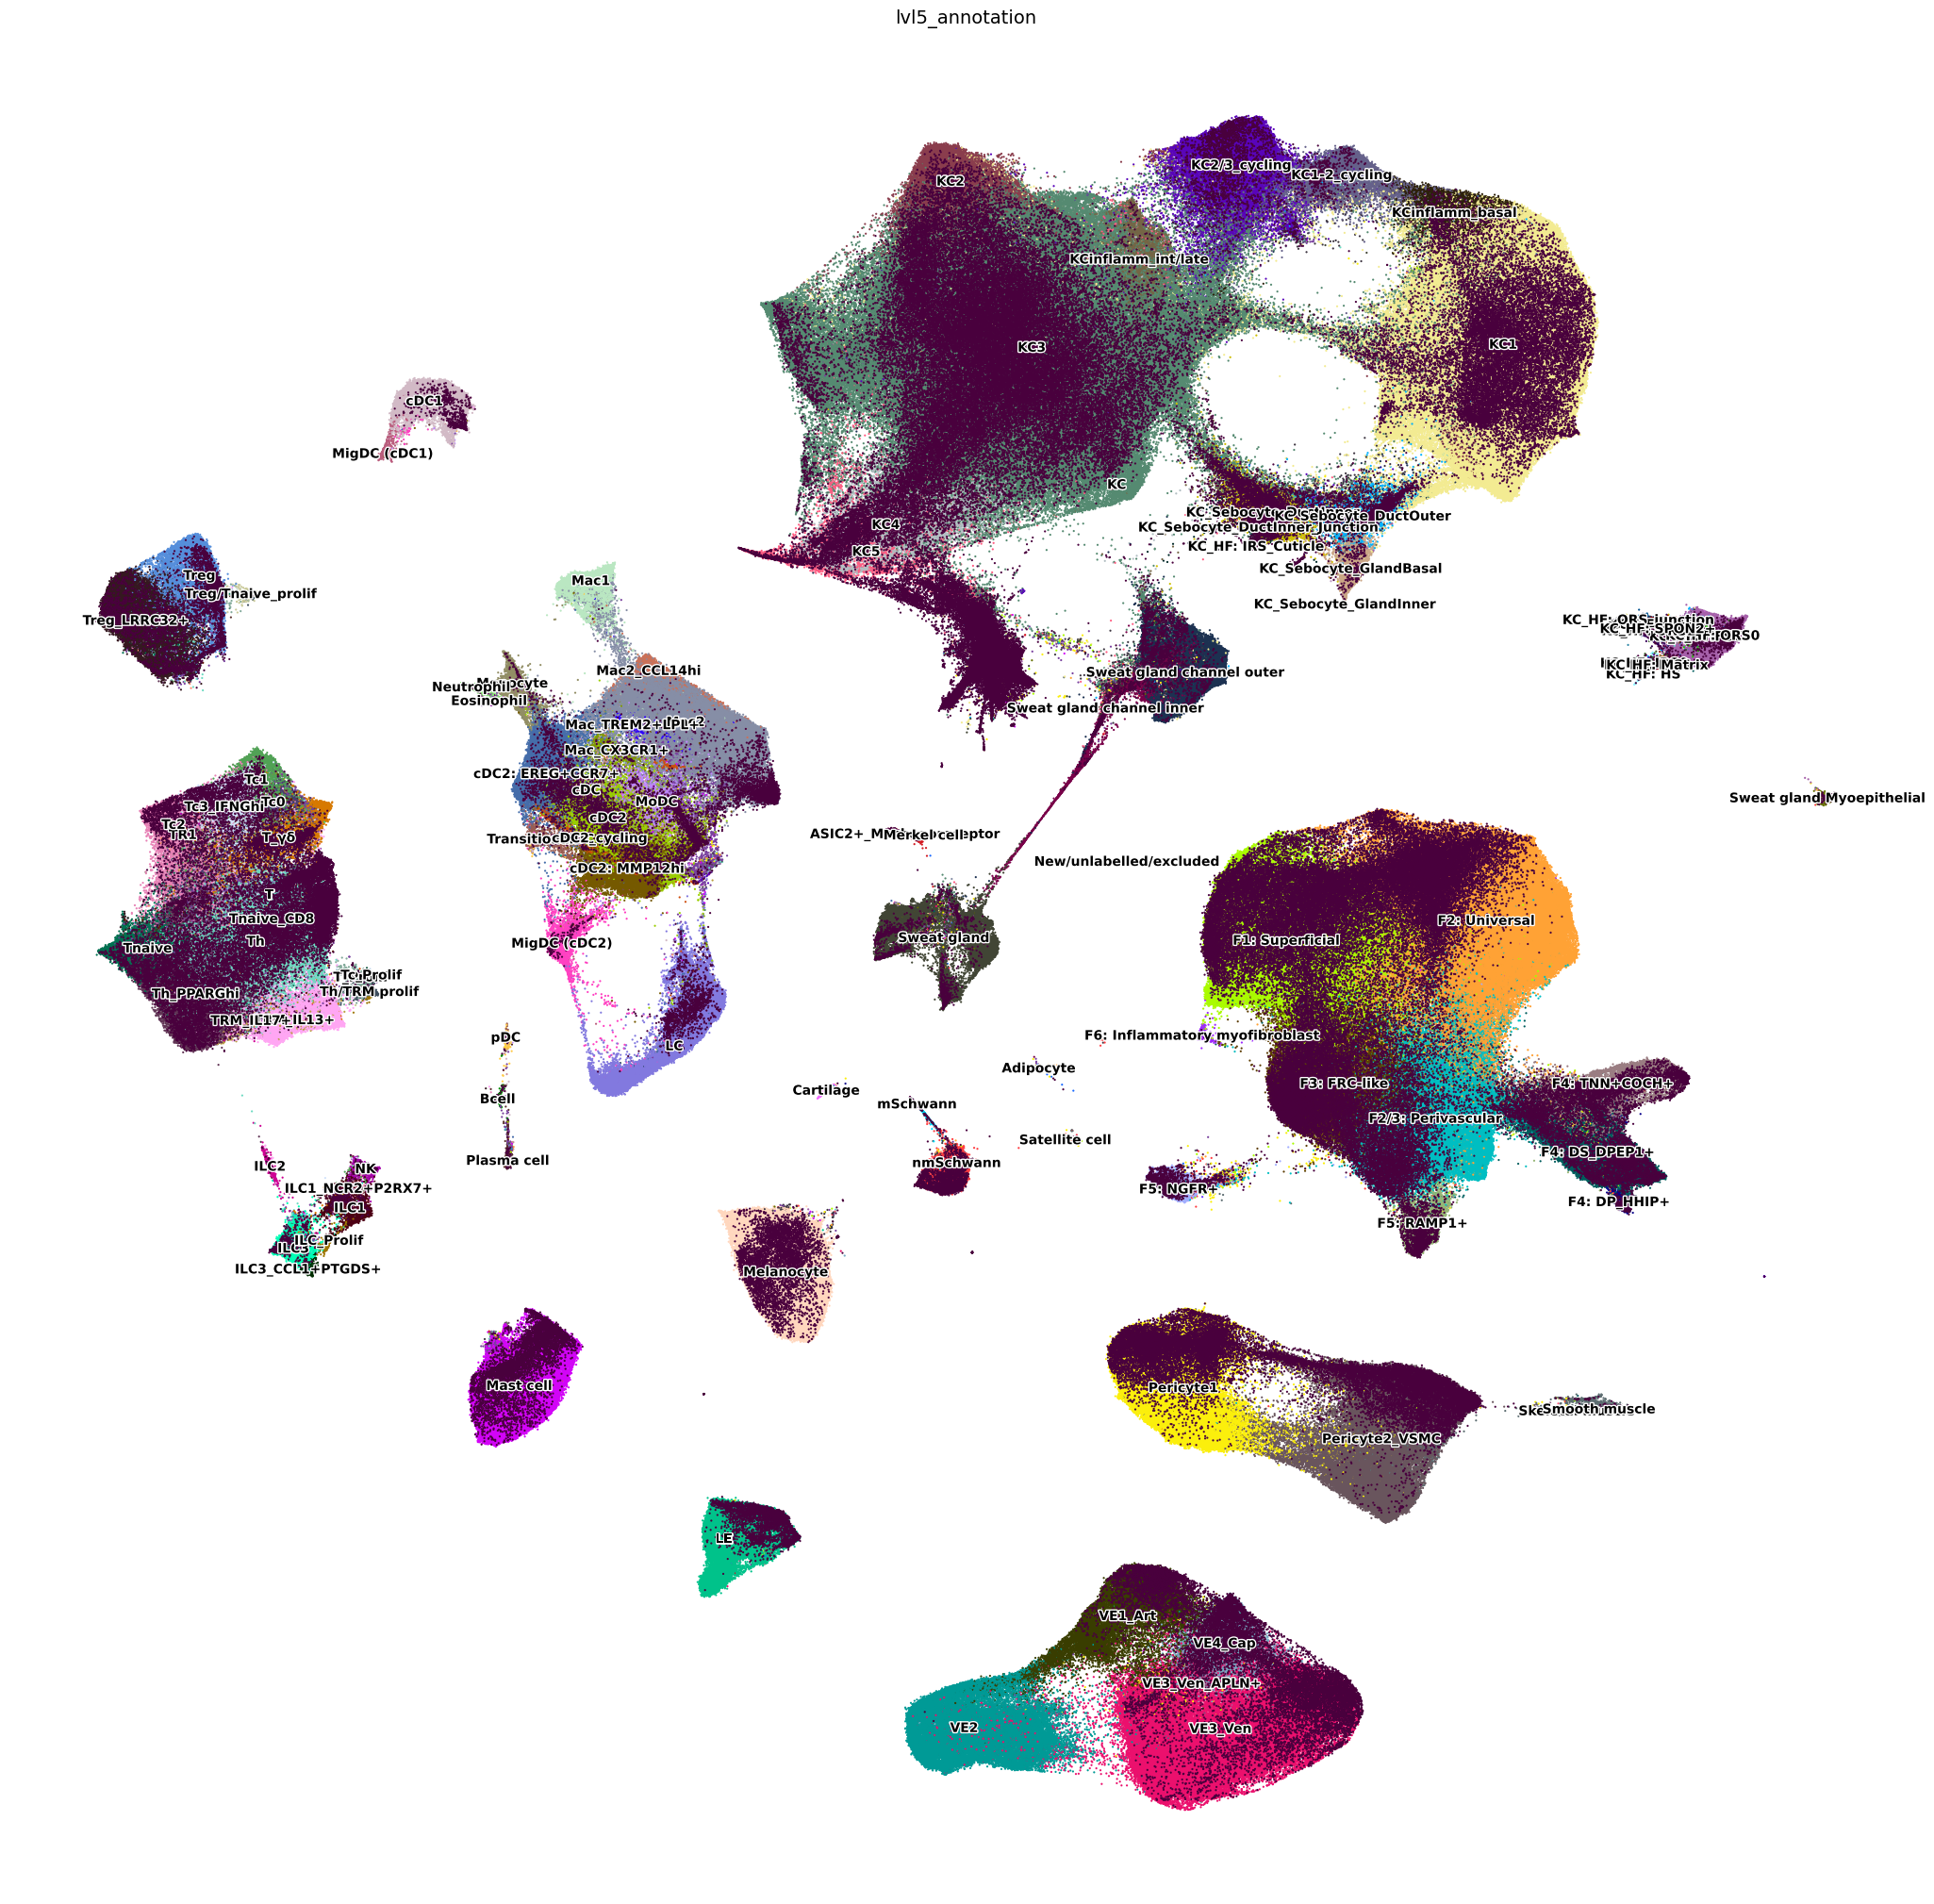

In [3]:
import glasbey
key = "lvl5_annotation"
cats = adata.obs[key].astype("category").cat.categories
palette = glasbey.create_palette(palette_size=len(cats), as_hex=True)
adata.uns[f"{key}_colors"] = palette

sc.pl.umap(
    adata,
    color=[key],
    legend_loc="on data",
    s=10,
    legend_fontsize=10,
    legend_fontoutline=2,
    show=False
)




/software/cellgen/team298/ls34/scpoli/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


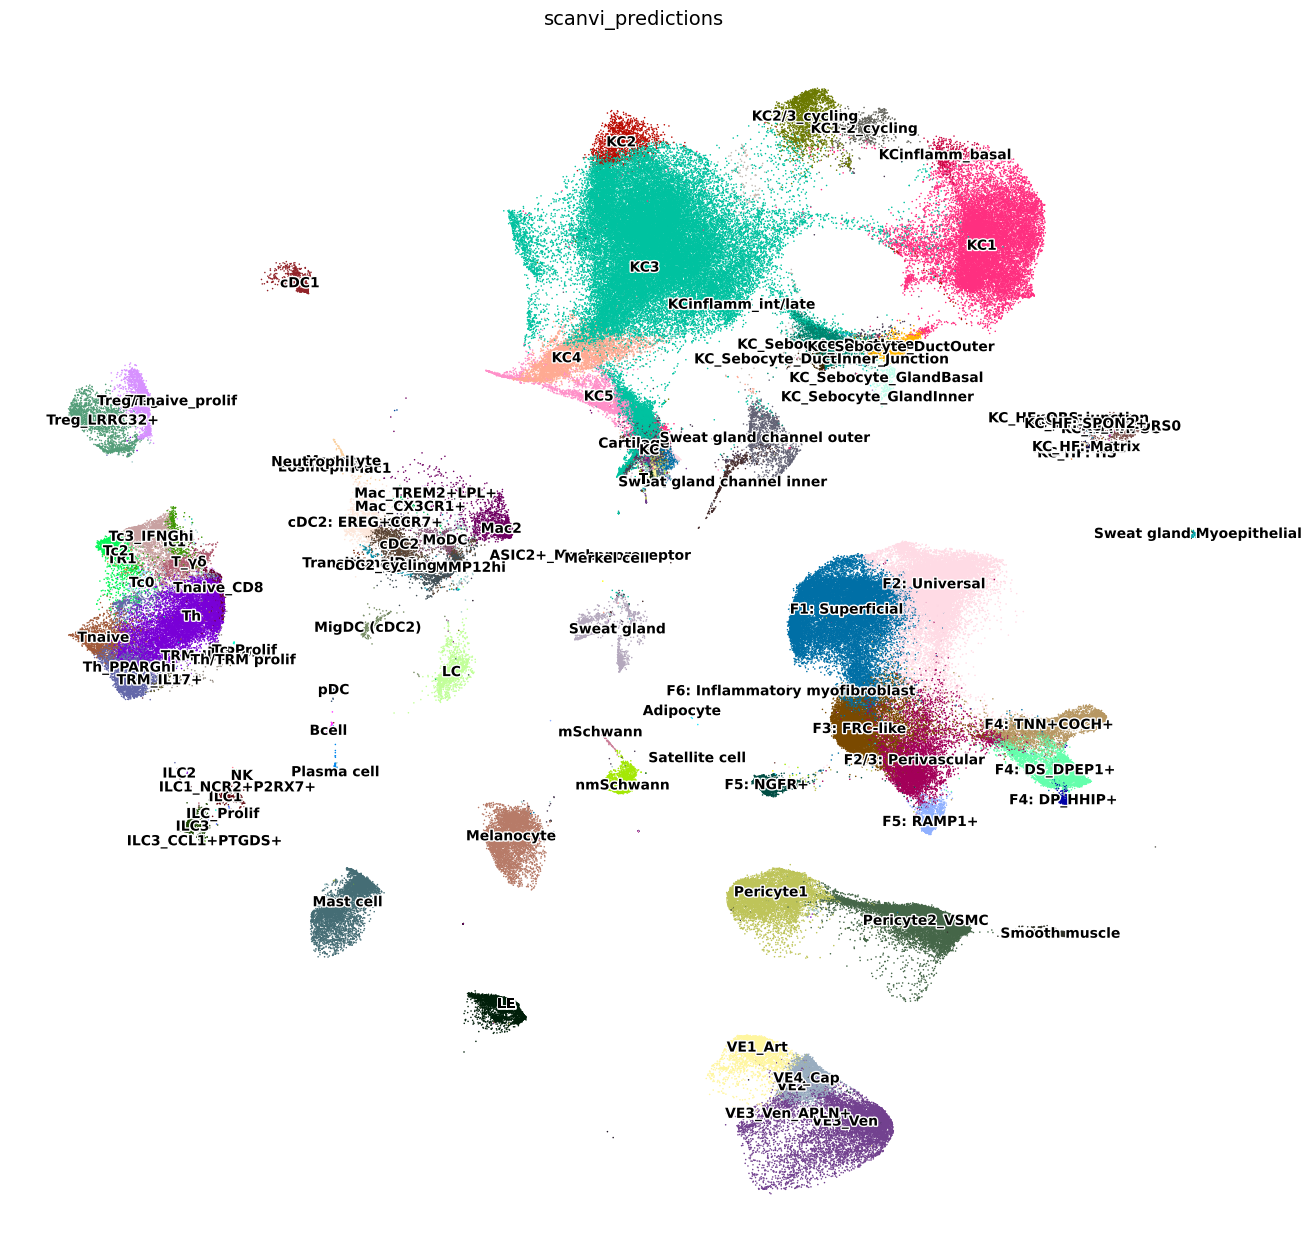

In [4]:
"""
We can also see what scanvi predictions are, but in my experience these have not been too reliable
compared to manually annotating the data.

However, not too bad for a quick overview.
"""
sc.settings.set_figure_params(dpi=50, dpi_save=300, facecolor="white", frameon=False, figsize=(16,16))

sc.pl.umap(
    adata[adata.obs["Mapping_status"]!="SpatialSkinAtlas"],
    color=[
        'scanvi_predictions',  
    ],
    legend_loc="on data",
    s=5, 
    legend_fontoutline=2,
    legend_fontsize=10,

)


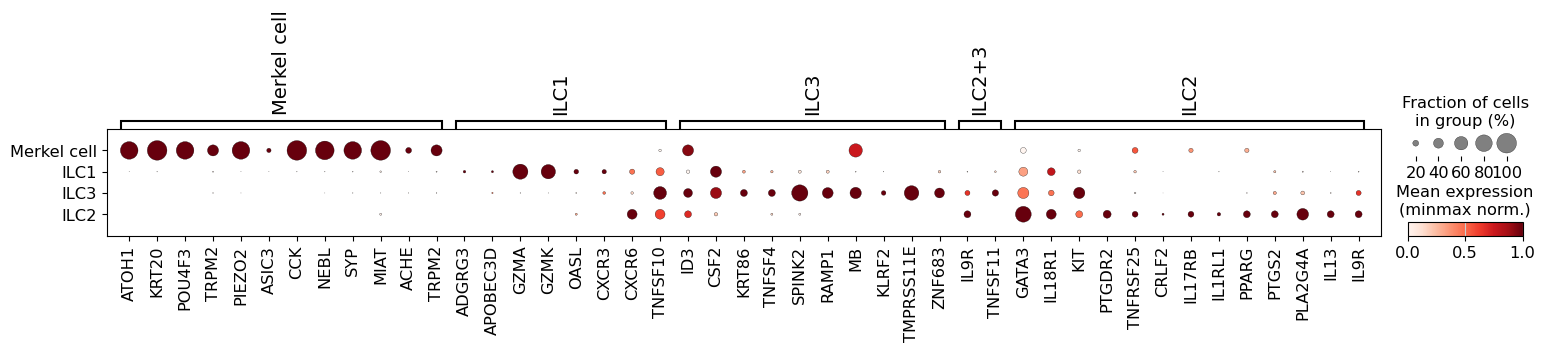

In [6]:
"""
Merkel cells were not in the original study. Nor ILCs. So let's check if these are correct
"""
# Exclude atlas data
adata = adata[adata.obs["Mapping_status"]!="SpatialSkinAtlas"].copy()
import gc
gc.collect()


# Normalise for plotting gene expression 
## NOTE THAT THIS OVERWRITES COUNT DATA SO WILL NOT SAVE AFTER THIS
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

MARKERS = { 
       
    
            "Merkel cell": ["ATOH1", "KRT20", "POU4F3", "TRPM2", "PIEZO2", "ASIC3", 
                           "CCK", "NEBL", "SYP", "MIAT", "ACHE","TRPM2",
                           ],
     
 
 
    "ILC1": [ "ADGRG3", "APOBEC3D", "GZMA", 'GZMK', 'OASL',  "CXCR3", 'CXCR6' , "TNFSF10" ],
 #         "ILC1_NKp46":  ['NCR1','NCAM1','P2RX7','ZNF407','IL18','ZBTB20','CASK','ITGA1',
 # 'PLCB1','ADAM28','CNR2'],
          'ILC3': ['ID3','CSF2', 'KRT86',
 # 'ZBTB46',
  'TNFSF4',
  'SPINK2',
  'RAMP1',
  'MB',
  'KLRF2',
  'TMPRSS11E', "ZNF683"],
          

 'ILC2+3': ['IL9R', 'TNFSF11'],
       'ILC2': ['GATA3',  'IL18R1','KIT', 'PTGDR2', 'TNFRSF25',
          'CRLF2',
  'IL17RB',
  'IL1RL1',

  'PPARG',
  'PTGS2',
  'PLA2G4A',
  #'IL4',

  'IL13',
          'IL9R'],
 
        
}

adata_i= adata[(adata.obs["scanvi_predictions"]=="ILC2")|
              (adata.obs["scanvi_predictions"]=="ILC1")|
                      (adata.obs["scanvi_predictions"]=="ILC3")|
                  (adata.obs["scanvi_predictions"]=="Merkel cell")
               
              ]
sc.pl.dotplot(
    adata_i,
    MARKERS,
    groupby="scanvi_predictions",
    standard_scale="var",
    dendrogram=False,
    vmax=1,
                               colorbar_title="Mean expression\n(minmax norm.)",
    categories_order = ["Merkel cell", "ILC1", "ILC3", "ILC2"],
                                  #  save="misc_scrna.pdf"

) 


In [ ]:
"""
So even with the scanvi predictions, we can resolve rare cell types not originally captured!
"""

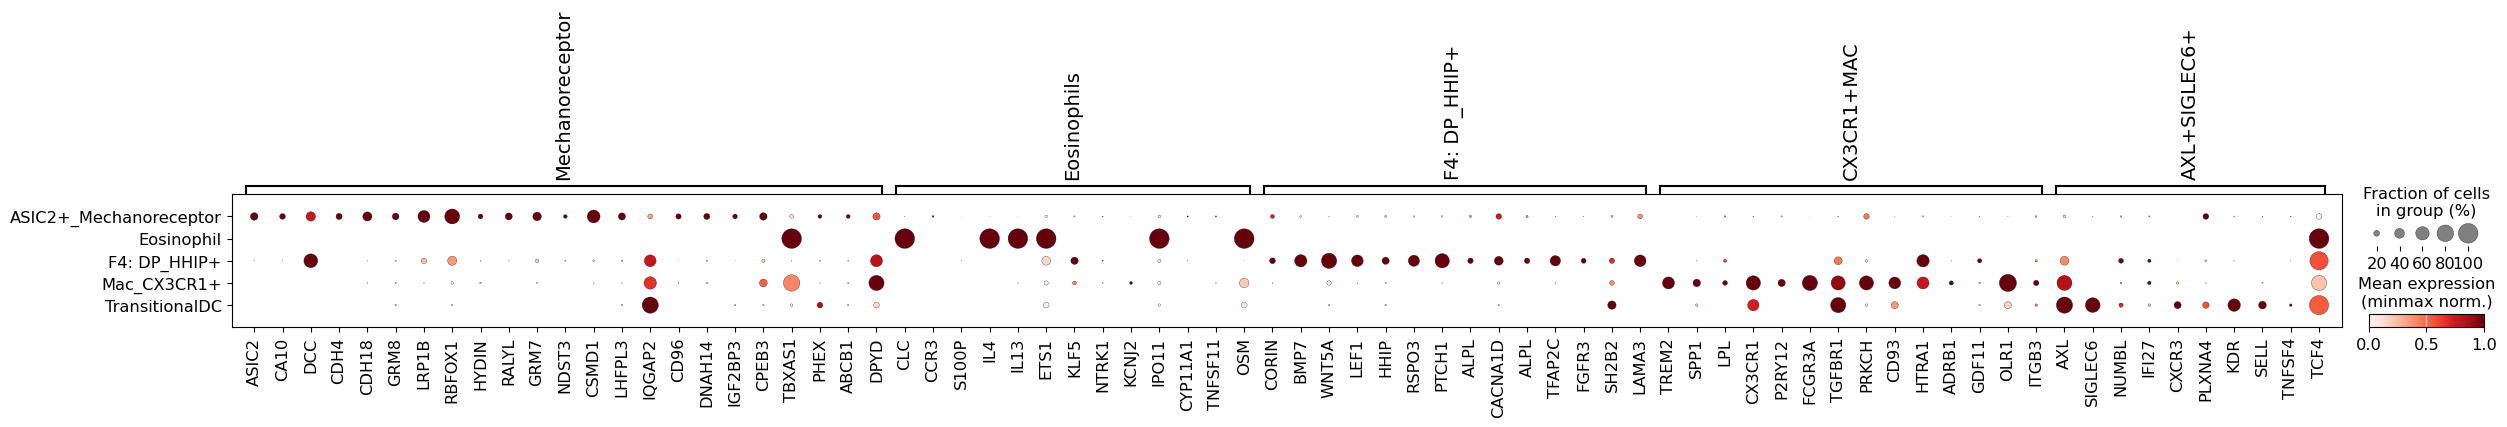

In [8]:
"""
I thought it would be interesting to check some of the other populations, like F4: DP_HHIP+, ASIC2+, TransitionalDC, 
Mac_CX3CR1+, 
+ eosinophils! 
"""
MARKERS = {     "Mechanoreceptor": ["ASIC2","CA10", "DCC", "CDH4", "CDH18","GRM8",
                        "LRP1B", #"IL1RAPL1","CTNNA2", "SUGCT", "NRXN1", "OPCML", 
               "RBFOX1", #"DOK6", 
               "HYDIN", #"RYR3",
               "RALYL", "GRM7", "NDST3",  'CSMD1','LHFPL3',
'IQGAP2', 'CD96', 'DNAH14', 'IGF2BP3', 'CPEB3', 'TBXAS1', 'PHEX', 'ABCB1', 'DPYD',                        
               #"HULC", "RYR3", "DMD", "ROBO2", "TENM2", "NRG3", "PCAT1", "CACNA2D3", 
               #"DLC1", "NAV3"
              
                       ],
            "Eosinophils": [ "CLC", "CCR3",#"CCL23",    #"PTGDR2", "P2RY1", 
                            "S100P",
                             "IL4",
    "IL13",
    "ETS1",
    "KLF5",
    "NTRK1",
    "KCNJ2",
    "IPO11",
    "CYP11A1",
    "TNFSF11",
    "OSM"
                           ], 
    
    'F4: DP_HHIP+': ['CORIN',
  'BMP7',
  'WNT5A',
  'LEF1',
  'HHIP',
  'RSPO3',
  #'INHBA',
  'PTCH1', "ALPL", "CACNA1D", "ALPL", "TFAP2C","FGFR3", "SH2B2","LAMA3",
],   
           'CX3CR1+MAC': ['TREM2', 'SPP1',  "LPL", 'CX3CR1', #'ADRB1', 
              # "KCNQ3"#"UNC5B", "GPR34", "SMAD7",  "CD72", "TGFBR1", 
             #  "CD9",
               
                "P2RY12", #'ADAMDEC1',
                'FCGR3A', 
                'TGFBR1', 'PRKCH', 'CD93', 'HTRA1', "ADRB1",
                'GDF11', 'OLR1', 'ITGB3'
               ],
             'AXL+SIGLEC6+': ['AXL', 'SIGLEC6', 'NUMBL', 'IFI27', 'CXCR3', 'PLXNA4', 'KDR', "SELL",
                             "TNFSF4", "TCF4"],    

        }
        
adata_i= adata[(adata.obs["scanvi_predictions"]=="Eosinophil")|
              (adata.obs["scanvi_predictions"]=="F4: DP_HHIP+")|
                      (adata.obs["scanvi_predictions"].str.startswith("ASIC2"))|
                                     (adata.obs["scanvi_predictions"].str.startswith("Mac_CX"))|

                  (adata.obs["scanvi_predictions"]=="TransitionalDC")
               
              ]
 



sc.pl.dotplot(
    adata_i,
    MARKERS,
    groupby="scanvi_predictions",
    standard_scale="var",
    dendrogram=False,
    vmax=1,
                               colorbar_title="Mean expression\n(minmax norm.)",
    #categories_order = ["Merkel cell", "ILC1", "ILC3", "ILC2"],
                                  #  save="misc_scrna.pdf"

) 


# Next steps would be clustering data 

In [ ]:
"""
In the examples in the paper, we processed specific clusters separately while retaining the atlas data (we would recommend this approach for xenium data in particular),
and then confirmed the populations were appropriately annotated later (see marker genes from supp figure 2-11 in paper)
"""

# Save scanvi_predictions to evaluate low-resource mapping

In [ ]:
stop

In [ ]:
import scanpy as sc
adata=sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/projects/adult_skin_v1/nobackup_output//SpatialSkinAtlasMapping_scanviSpatialSkinAtlasMapping_TUTORIAL_HVGNUMBER5704__MAXEPOCHS10__BATCHKEYsample_id/adata_all_TUTORIAL+HVGNUMBER5704__MAXEPOCHS10__BATCHKEYsample_id.h5ad')

In [ ]:
adata = adata[adata.obs["Mapping_status"]!="SpatialSkinAtlas"].copy()
import gc
gc.collect()

In [ ]:
scanvi_predictions_dict = adata.obs["scanvi_predictions"].to_dict()

import pickle
scanvi_predictions_dict = adata.obs["scanvi_predictions"].to_dict()

outpath = "/nfs/team298/ls34/dicts/tutorial_scanvi_predictions.pkl"


with open(outpath, "wb") as f:
    pickle.dump(scanvi_predictions_dict, f)

print("Saved to:", outpath)